# Actividad 3

Ejercicio relativo a la actividad 3 de la asignatura Percepción Computacional

Alumno: Manuel Naranjo Martínez, Grupo: FUNDAE

## Importación de librerías y funciones accesorias

In [1]:
# Para medir el tiempo de ejecución
import time
# Para mostrar las imágenes
import matplotlib.pyplot as plt
# Para transformar imágenes a escala de grises
# from skimage.color import rgb2gray
# Para uso de la librería numpy de operaciones matriciales
import numpy as np

# Conversión a escala de grises
from skimage.color import rgb2gray

# Para cargar las funciones de implementación propia
# necesarias para realizar el ejercicio
from my_functions2 import segm_felzenszwalb, segm_watershed, \
                          segm_quickshift, segm_rag, \
                          calculate_metrics, get_reference_masks

In [2]:
def imshow(img):
    """
    Función para mostrar una imagen eliminando los ejes
    
    Args:
        img (Numpy Array): Imagen a mostrar
    """
    fig, ax = plt.subplots(figsize=(7, 7))
    # El comando que realmente muestra la imagen
    ax.imshow(img, cmap=plt.cm.gray)
    # Para evitar que aparezcan lso números en los ejes
    ax.set_xticks([]), ax.set_yticks([])
    plt.show()

def plot_comparison(img_l, img_r, r_title, l_title):
    """
    Función para mostrar dos imágenes en paralelo para compararlas
    
    Args:
        img_l (Numpy Array): Imagen de la izq.
        img_r (Numpy Array): Imagen de la derecha
        
    """
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 20), sharex=True,
                                  sharey=True)
    
    ax1.imshow(img_l, cmap=plt.cm.gray)
    ax1.set_title(r_title)
    ax1.axis('off')
    ax1.set_adjustable('box')
    ax2.imshow(img_r, cmap=plt.cm.gray)
    ax2.set_title(l_title)
    ax2.axis('off')
    ax2.set_adjustable('box')
    plt.show()

# Dominio de la aplicación

El dominio elegido para el ejercicio de segmentación es la obtención de máscaras de los barcos en imágenes satelitales como las del dataset de Airbus del reto de Kaggel [0].

La finalidad es conseguir detectar el barco mediante la obtención del segmento del mismo.

Se mostará la comparativa de la aplicación de cuatro segmentadores sobre tres imágenes de ejemplo, mostrando sus resultados de forma vistual, así como los tiempos de ejecución de cada uno de ellos. También se describirá como la modificación de ciertos parámetros (dependiendo del segmentador) pueden afectar para mejorar/empeorar la segmentación para este caso concreto. Dichos valores serán los asignados en las implementaciones propias de las funciones segmentadores del fichero adjunto.

Cómo punto final, se elegirá uno de ellos y se llevará a cabo su evaluación mediante métricas (accuracy, specificity, sensibility, IoU, ..) para comprobar cómo de bien se lleva a cabo la segmentación. Para esta comprobación será necesario utilizar la máscara de referencia obtenida del dataset original de Kaggel [0].

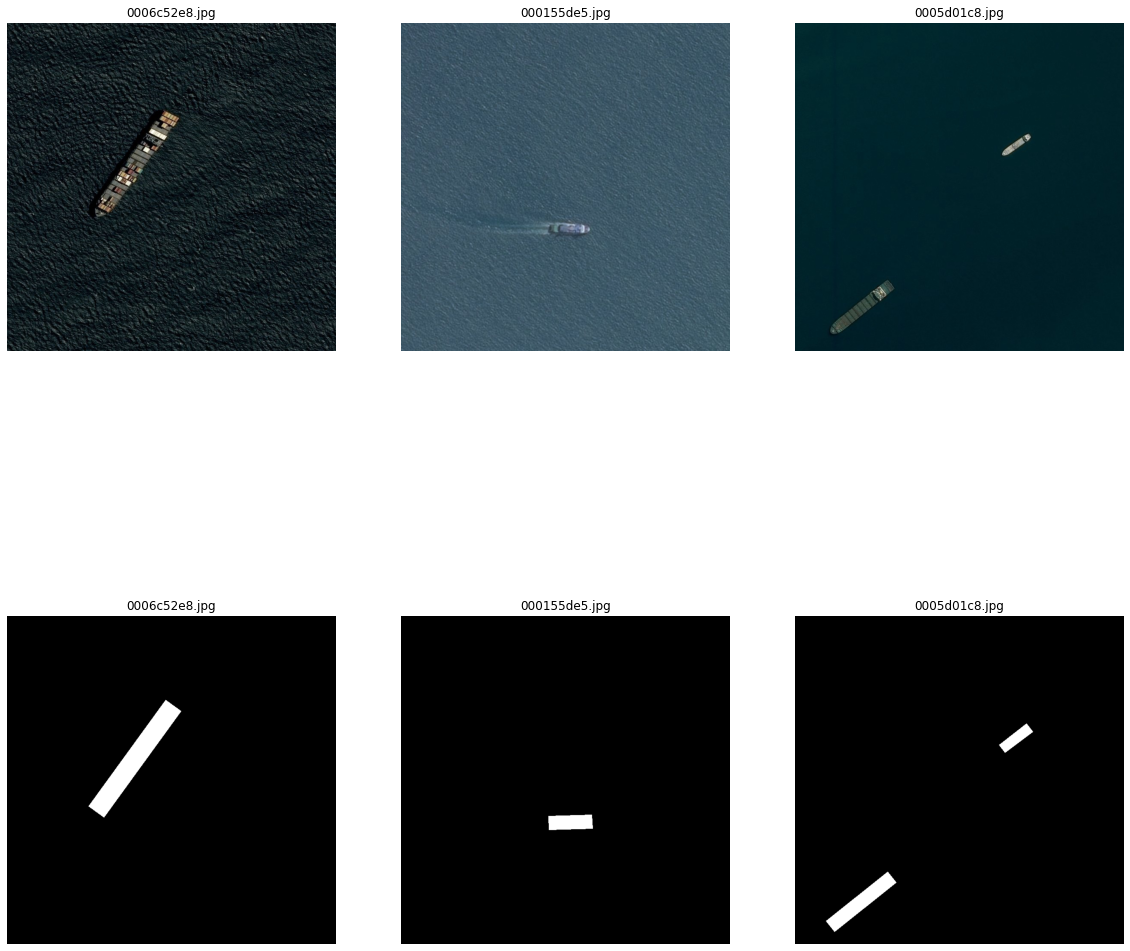

In [3]:
# Listado de imágenes a tratar
imgs_ids = ['0006c52e8.jpg', '000155de5.jpg', '0005d01c8.jpg']

# Obtenemos las máscaras de las imágenes a tratar
masks = get_reference_masks('train_ship_segmentations_v2.csv', imgs_ids)

fig, axis = plt.subplots(nrows=2, ncols=len(masks),
                                  figsize=(20, 20),
                                  sharex=True,
                                  sharey=True)

for i, img in enumerate(imgs_ids):
    axis[0][i].imshow(plt.imread(img))
    axis[0][i].set_title(imgs_ids[i])
    axis[0][i].axis('off')
    axis[0][i].set_adjustable('box')
    
    axis[1][i].imshow(masks[i], cmap=plt.cm.gray)
    axis[1][i].set_title(imgs_ids[i])
    axis[1][i].axis('off')
    axis[1][i].set_adjustable('box')

plt.show()

# Experimentación con Segmentadores

## Felzenszwalb

* **scale**: A mayor, más grandes son los grupos. Default 800. 
    1. Con *scale* bajo, la zona de detección alrededor del objeto se ve incrementado y llega a detectar elementos no deseados en el mar.
    2. Con *scale* alto, se va reduciendo la zon de detección al rededor de los objetos relevantes, llegando a desaparecer si es muy elevado.
    

* **sigma**: Desviación estándar del kernel Gaussiano. Default 10
    1. Con *sigma* bajo, las formas de los objetos a detectar se ajustan, pero se detecta demasiado ruido en las partes blancas del agua por el oleaje.
    2. Con *sigma* alto, deja de detectar elementos, más allá de un valor 20, las segmentaciones desaparecen en casi todos los casos.
    
    
* **min_size**: Size minimo de los componentes. Default 5
    1. Con *min_size* bajo, se reduce el tamaño mínimo necesario de los elementos para ser detectados. Se detectan más elementos
    2. Con *min_size* alto, se detectan menos elementos, se requiere un tamaño mayor del elemento para ser detectado.

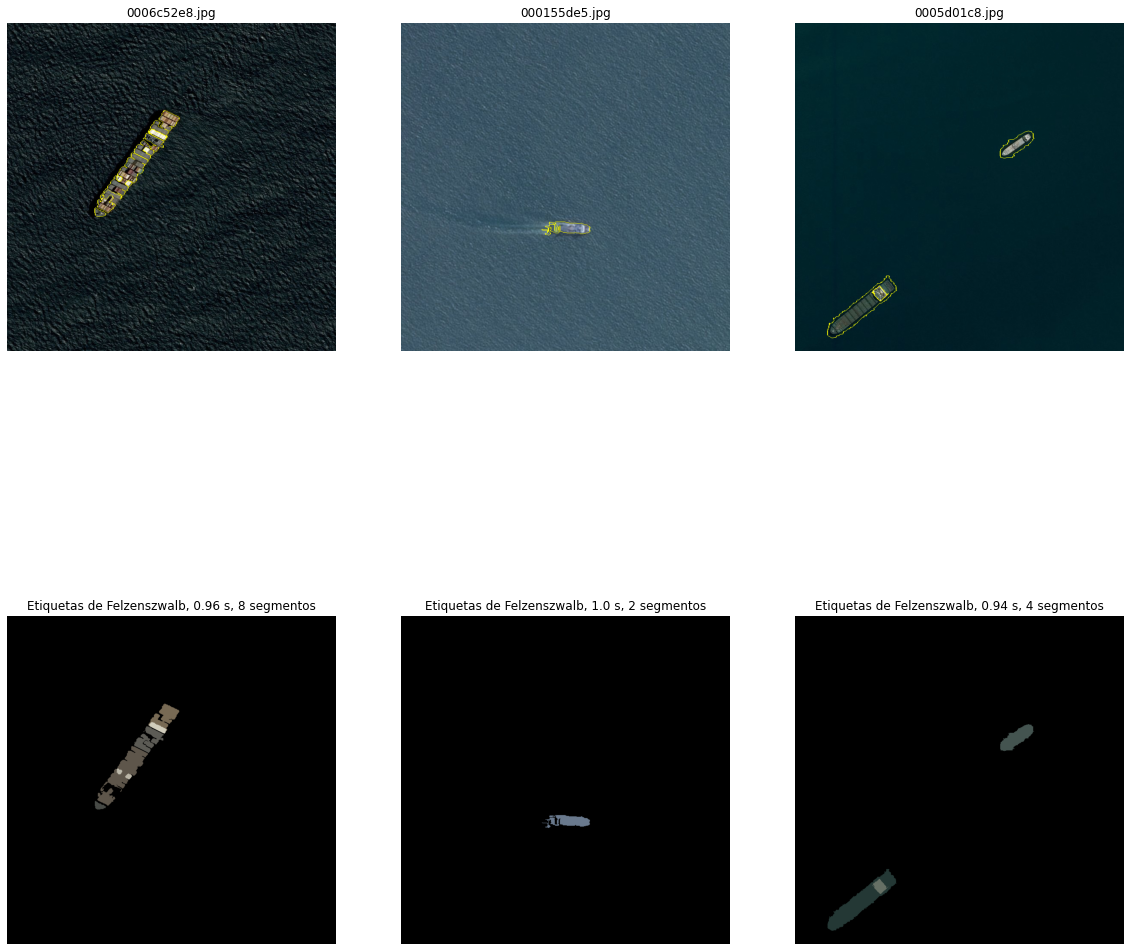

In [4]:
fig, axis = plt.subplots(nrows=2, ncols=len(imgs_ids), figsize=(20, 20), sharex=True,
                                  sharey=True)
for i, img in enumerate(imgs_ids):
    start_time = time.time()
    # Aplicación de la segmentación Felzenszwalb para cada una de las imagenes
    # Valores óptimos de scale, sigma y min_size para la solución del ejercicio
    (output_image, labeled_fz, segments_felzenszwalb) = segm_felzenszwalb(plt.imread(img), 
                                                                          scale=2000, 
                                                                          sigma=1,
                                                                          min_size=100)
    end_time = time.time()
    
    duration_felzenszwalb = round(end_time-start_time, 2)
    
    axis[0][i].imshow(output_image)
    axis[0][i].set_title(imgs_ids[i])
    axis[0][i].axis('off')
    axis[0][i].set_adjustable('box')
    
    axis[1][i].imshow(labeled_fz)
    axis[1][i].set_title("Etiquetas de Felzenszwalb, {} s, {} segmentos".format(
                                                duration_felzenszwalb, 
                                                segments_felzenszwalb))
    axis[1][i].axis('off')
    axis[1][i].set_adjustable('box')
    
plt.show()

## Watershed

* **gradient_level**: Nivel del gradiente para encontrar regiones continuas. Default 10. 
    1. Con *gradient_level* bajo, Incremento considerable en el tiempo de ejecución y detección excesiva de regiones.
    2. Con *gradient_level* alto, Reducción de regiones detectadas llegando a desaparecer por encima de un valor de 20 para el caso del ejercicio.
    

* **denoised_d_radius**: Radio del elemento morfologico 'diamond' para obtener una imagen más suave. Default 10
    1. Con *denoised_d_radius* bajo, Incremento del tiempo de ejecución, además de generar un elevadísimo número de segmentos.
    2. Con *denoised_d_radius* alto, Reducción de elementos a segmentar, eliminando casi todos los detalles con valores por encima de 20

<ipython-input-5-c4e9621b7522>:7: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  (output_image, labeled_ws, segments_watershed) = segm_watershed(plt.imread(img))


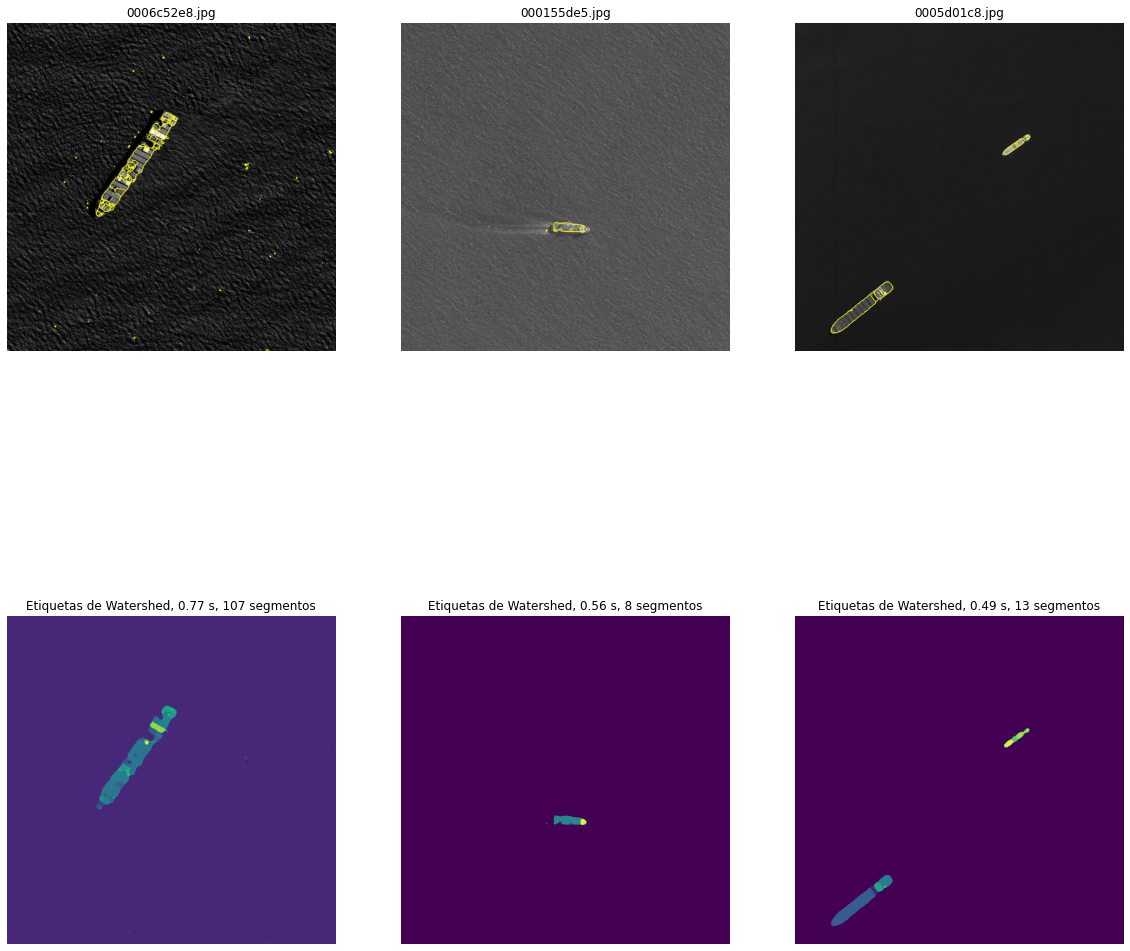

In [5]:
fig, axis = plt.subplots(nrows=2, ncols=len(imgs_ids), figsize=(20, 20), sharex=True,
                                  sharey=True)
for i, img in enumerate(imgs_ids):
    start_time = time.time()
    # Aplicación de la segmentación Felzenszwalb para cada una de las imagenes
    # Valores óptimos, valores por defecto
    (output_image, labeled_ws, segments_watershed) = segm_watershed(plt.imread(img))
    end_time = time.time()
    
    duration_watershed = round(end_time-start_time, 2)
    
    axis[0][i].imshow(output_image)
    axis[0][i].set_title(imgs_ids[i])
    axis[0][i].axis('off')
    axis[0][i].set_adjustable('box')
    
    axis[1][i].imshow(labeled_ws)
    axis[1][i].set_title("Etiquetas de Watershed, {} s, {} segmentos".format(
                                                                        duration_watershed, 
                                                                        segments_watershed))
    axis[1][i].axis('off')
    axis[1][i].set_adjustable('box')
    
plt.show()

## Quickshift

* **ratio**: Balance del espacio de color. Default 0.1
    1. Con *ratio* bajo, Reducción del número de secciones detectadas
    2. Con *ratio* alto, Incremento muy elevado del número de regiones detectadas, y del tiempo de ejecución.
    

* **kernel_size**: Ancho del kernel Gaussiano. A mayor valor, menos clusters. Default 10
    1. Con *kernel_size* bajo, Incremento del tiempo de ejecución y del número de regiones
    2. Con *kernel_size* alto, Incremento enorme del tiempo de ejecución (por encima de 10 el orden de magnitud se convirte en minutos), Reducción del número de regiones.
    
    
* **max_dist**: Punto de corte para las distancias de los datos. Más alto significa menos clusters. Default 25
    1. Con *max_dist* bajo, Incremento enorme del tiempo de ejecución (por debajo de 10 el orden de magnitud se convirte en minutos). Incremento del número de regiones.
    2. Con *max_dist* alto, Reducción del número de regiones.
    



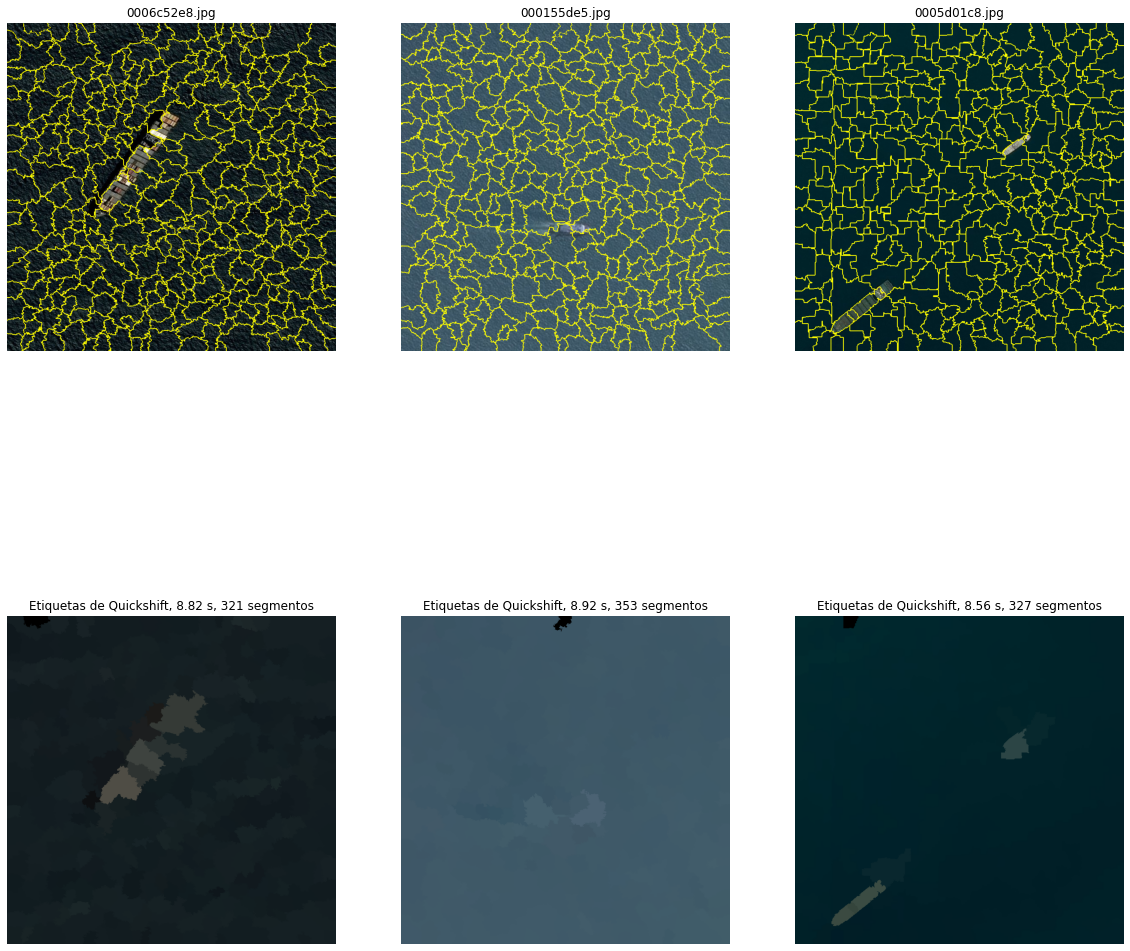

In [6]:
fig, axis = plt.subplots(nrows=2, ncols=len(imgs_ids), figsize=(20, 20), sharex=True,
                                  sharey=True)
for i, img in enumerate(imgs_ids):
    start_time = time.time()
    # Aplicación de la segmentación Felzenszwalb para cada una de las imagenes
    # Valores óptimos, valores por defecto
    (output_image, labeled_qs, segments_quickshift) = segm_quickshift(plt.imread(img))
    end_time = time.time()
    
    duration_quickshift = round(end_time-start_time, 2)
    
    axis[0][i].imshow(output_image)
    axis[0][i].set_title(imgs_ids[i])
    axis[0][i].axis('off')
    axis[0][i].set_adjustable('box')
    
    axis[1][i].imshow(labeled_qs)
    axis[1][i].set_title("Etiquetas de Quickshift, {} s, {} segmentos".format(
                                                                duration_quickshift,
                                                                segments_quickshift))
    axis[1][i].axis('off')
    axis[1][i].set_adjustable('box')
    
plt.show()

## RAG


* **compactness**: Equilibra proximidad de color y espacio. Default 10
    1. Con *compactness* bajo, Desaparecen casi todos los segmentos con un valor de 1
    2. Con *compactness* alto, Encuentra más segmentos
    

* **n_segments**: El número aproximado de etiquetas en la imagen de salida. Default 275
    1. Con *n_segments* bajo, Pueden llegar a desaparecen las regiones y no encontrar ninguna.
    2. Con *n_segments* alto, Incrementa el número de etiquetas que se asignan a las regiones detectadas.
    
    
* **sigma**: Anchura del núcleo de suavizado Gaussiano. Default 1
    1. Con *sigma* bajo, se reduce el número de segmentos encontrados, pudiendo llegar a desaparecen en varios casos.
    2. Con *sigma* alto, Se incrementa el número de segmentos encontrados.
    

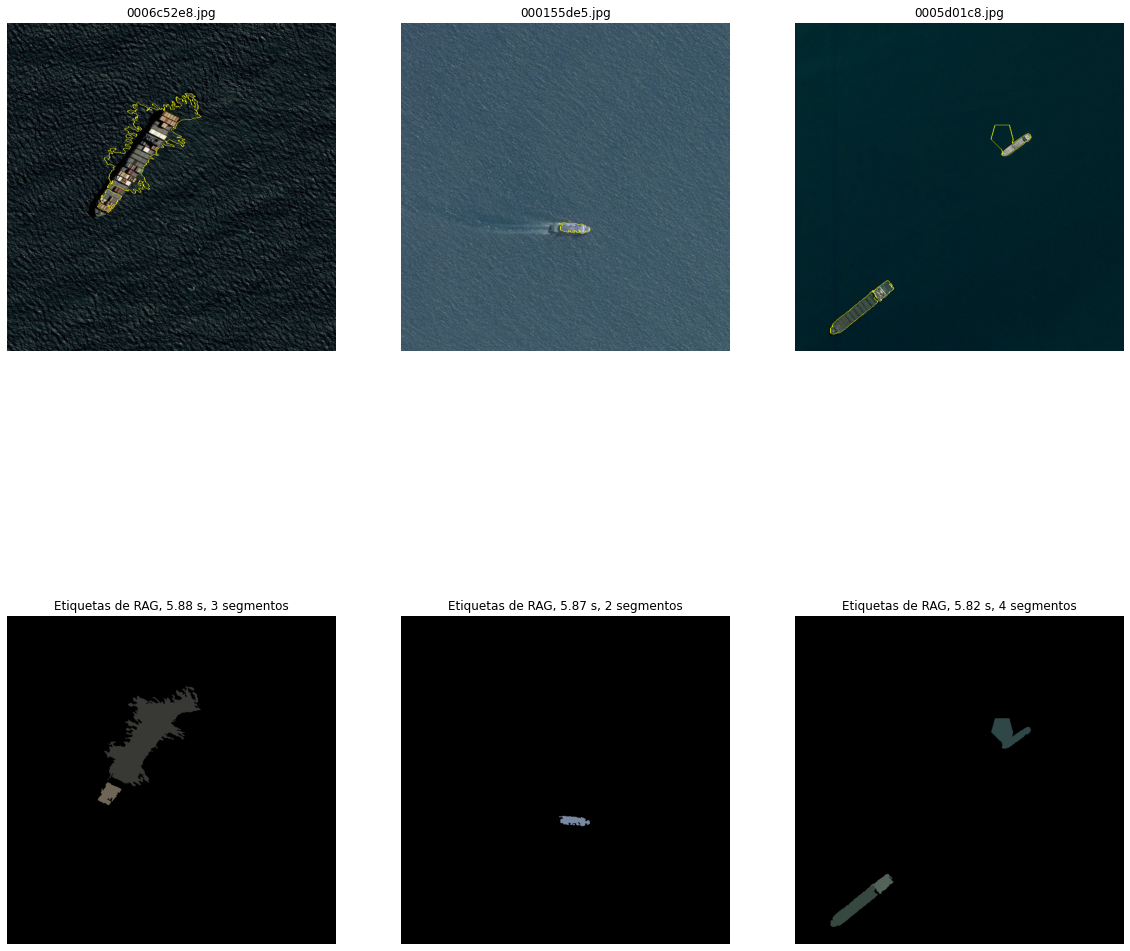

In [7]:
fig, axis = plt.subplots(nrows=2, ncols=len(imgs_ids), figsize=(20, 20), sharex=True,
                                  sharey=True)
for i, img in enumerate(imgs_ids):
    start_time = time.time()
    # Aplicación de la segmentación Felzenszwalb para cada una de las imagenes
    # Valores óptimos, valores por defecto
    (output_image, labeled_rag, segments_rag) = segm_rag(plt.imread(img))
    end_time = time.time()
    
    duration_rag = round(end_time-start_time, 2)
    
    axis[0][i].imshow(output_image)
    axis[0][i].set_title(imgs_ids[i])
    axis[0][i].axis('off')
    axis[0][i].set_adjustable('box')
    
    axis[1][i].imshow(labeled_rag)
    axis[1][i].set_title("Etiquetas de RAG, {} s, {} segmentos".format(duration_rag, 
                                                                       segments_rag))
    axis[1][i].axis('off')
    axis[1][i].set_adjustable('box')
    
plt.show()

# Evaluación del segmentador

Una vez visto los resultados comparativos de los 4 procesos segmentadores "Felzenszwalb", "Watershed", "QuickShift" y "RAG", por calidad de resultados visuales y tiempo de ejecución en cada caso, se ha decidido utilizar como solución **Felzenszwalb** con los valores de scale=2000, sigma=1 y min_size=100.

<ipython-input-8-cf9a5d0a7e96>:18: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  im_binary= rgb2gray(labeled) > np.min(labeled)


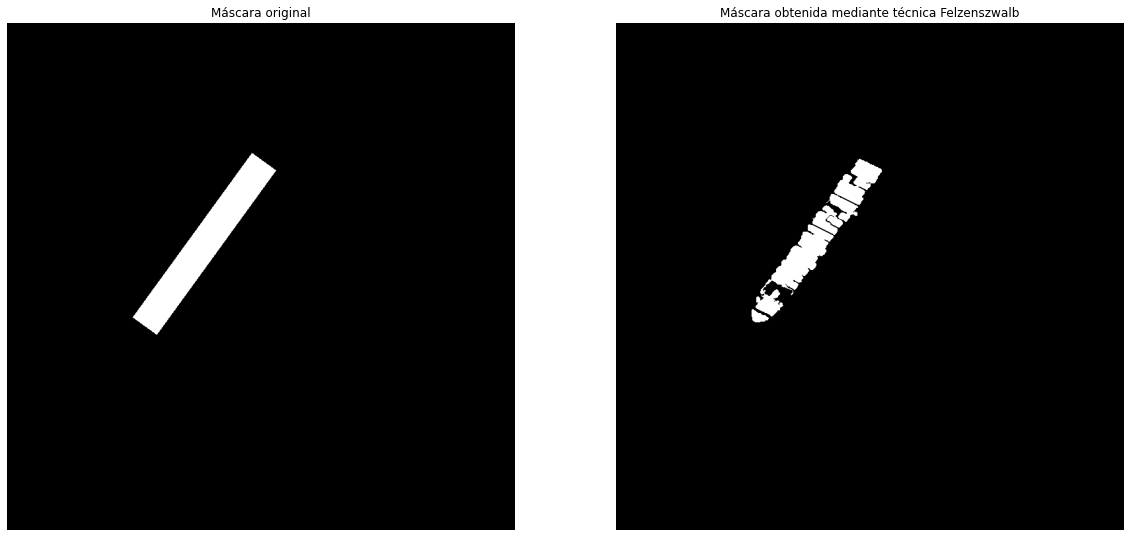

C:\Users\mnara\Documents\MásterIA\1erSemestre\Asignaturas\PercepcionComputacional\Actividades\Actividad3\repositorio_github\my_functions2.py:82: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  intersection = np.logical_and(rgb2gray(labeled_img), gt)
C:\Users\mnara\Documents\MásterIA\1erSemestre\Asignaturas\PercepcionComputacional\Actividades\Actividad3\repositorio_github\my_functions2.py:83: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  union = np.logical_or(rgb2gray(labeled_img), gt)


Accuracy:	0.9929826524522569
Error rate:	0.00701734754774308
Precission:	0.9931243680485339
Recall:	0.7069747354782985
F1:	0.8259681284951437
Sensibility:	0.7069747354782985
Specificity:	0.9998819303006784
IoU:	0.7035312656686484
Pixeles predichos: 9890 - pixeles originales: 13893


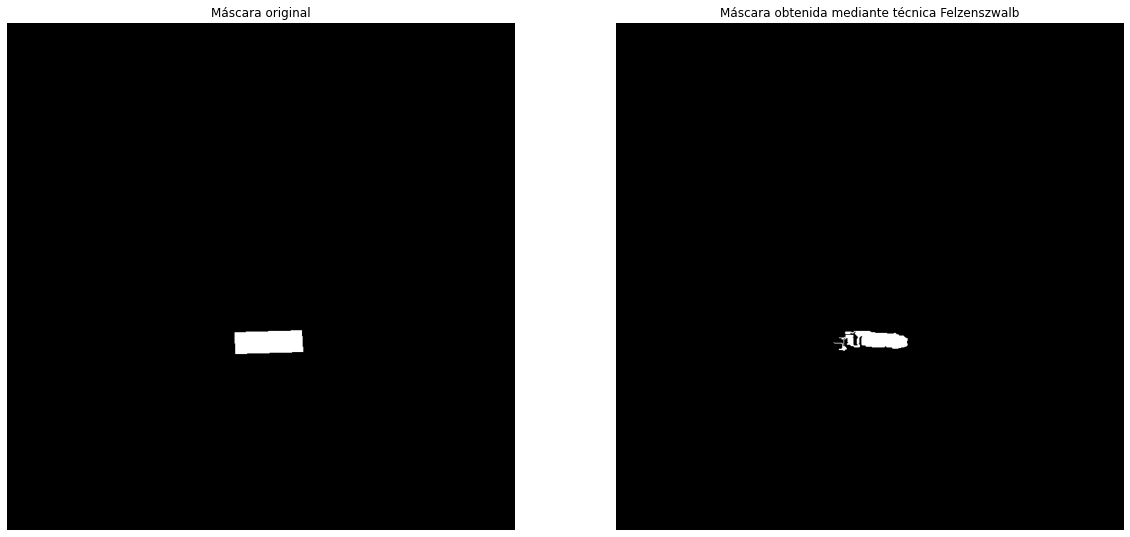

Accuracy:	0.9971872965494791
Error rate:	0.0028127034505208703
Precission:	0.9476954945624029
Recall:	0.5401416765053129
F1:	0.6880992667794698
Sensibility:	0.5401416765053129
Specificity:	0.9998277731926416
IoU:	0.524505588993981
Pixeles predichos: 1931 - pixeles originales: 3388


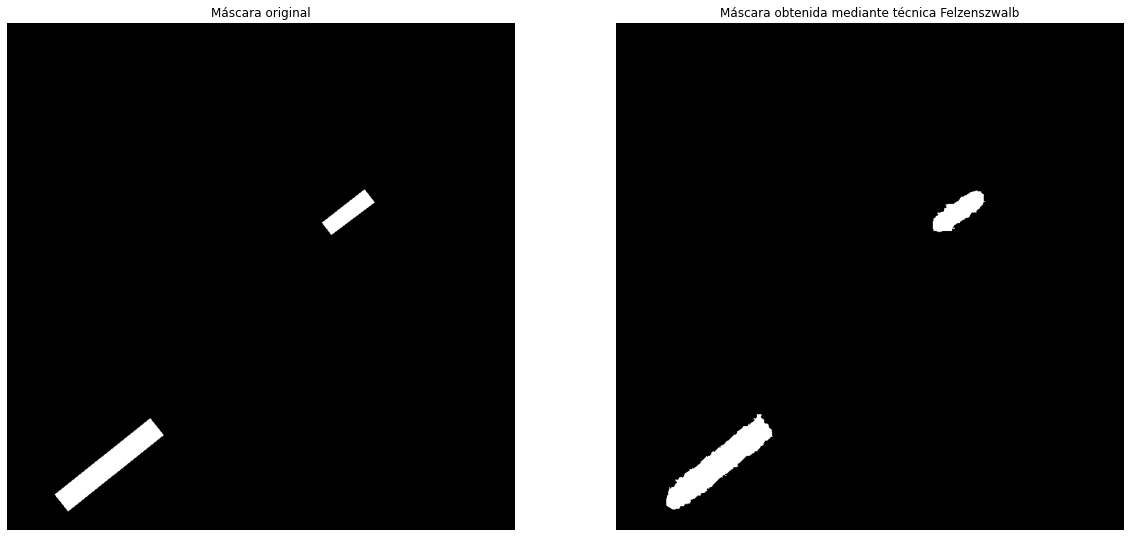

Accuracy:	0.9970957438151041
Error rate:	0.0029042561848958703
Precission:	0.8339467872541803
Recall:	0.9833829365079365
F1:	0.9025209127638991
Sensibility:	0.9833829365079365
Specificity:	0.9972858223322332
IoU:	0.8223581872861143
Pixeles predichos: 9509 - pixeles originales: 8064


In [8]:
# Lista de resultados para las imágenes de prueba
results = []
# Cálculo de segmentación
for i, img in enumerate(imgs_ids):
    (output_image, labeled_fz, segments_felzenszwalb) = segm_felzenszwalb(plt.imread(img), scale=2000, 
                                                                                           sigma=1,
                                                                                           min_size=100)
    results.append(labeled_fz)

    
# Obtención de métricas
for i, result in enumerate(results):
    labeled = rgb2gray(result)

    # Elección de la máscara relativa asociada al resultado
    mask = masks[i]
    
    im_binary= rgb2gray(labeled) > np.min(labeled)
    plot_comparison(mask, im_binary, "Máscara original", "Máscara obtenida mediante técnica Felzenszwalb")

    (accuracy, error_rate, precission, 
     recall, F1, sensibility, specificity, 
     iou, num_px_predicted, num_px_gt) = calculate_metrics(im_binary, mask)

    print("Accuracy:\t{}\nError rate:\t{}\nPrecission:\t{}\n" \
          "Recall:\t{}\nF1:\t{}\nSensibility:\t{}\nSpecificity:\t{}\nIoU:\t{}".format(accuracy,
                                                                                     error_rate,
                                                                                     precission,
                                                                                     recall,
                                                                                     F1,
                                                                                     sensibility,
                                                                                     specificity,
                                                                                     iou))

    print("Pixeles predichos: {} - pixeles originales: {}".format(num_px_predicted, num_px_gt))

# Conclusiones

Durante la aplicación de las técnicas de segmentación, se ha podido comprobar la gran complejidad del proceso, destacando la diferencia entre la aplicación de segmentación para un entorno y finalidad u otro (convirtiéndose en un problema totalmente diferente).

En nuestro ejemplo concreto, con la segmentación Felzenszwalb, podemos apreciar como en 2 de los tres casos se ha conseguido una buena segmentación (consiguiendo valores por encima del 70% en el primer y tercer ejemplo), así como altos valores den precisión, accuracy, F1, sensiblidad y especificidad. El caso en el que peores valores se han obtenido es en el que aparece un barco de menor tamaño y en movimiento (dificultando el trabajo con la estela del mismo).

# Referencias

0. Obtención del datasets para aplicación del dominio del problema: https://www.kaggle.com/c/airbus-ship-detection/data
1. Cálculo del IoU: https://towardsdatascience.com/intersection-over-union-iou-calculation-for-evaluating-an-image-segmentation-model-8b22e2e84686
2. Uso y ejemplos de Felzenszwalb: https://www.programcreek.com/python/?code=rusty1s%2Fgraph-based-image-classification%2Fgraph-based-image-classification-master%2Fsegmentation%2Falgorithm%2Ffelzenszwalb.py
3. Métricas y evaluación de segmentación: https://towardsdatascience.com/metrics-to-evaluate-your-semantic-segmentation-model-6bcb99639aa2
4. Uso y ejemplo de Watershed: https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_marked_watershed.html
5. Usos y ejemplos RAG: https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_rag_draw.html y https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_rag_mean_color.html
6. Comparativas: https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_segmentations.html
7. Obtener imagen de encoded pixels: https://medium.com/analytics-vidhya/generating-masks-from-encoded-pixels-semantic-segmentation-18635e834ad0